# Análise de técnicas de agrupamento de dados para notícias de futebol

## Carregando os dados

Os dados serão importados da base de dados `ge-soccer-clubs-news`, disponível em [link](https://www.kaggle.com/datasets/lgmoneda/ge-soccer-clubs-news).

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ge_news_all_2022.csv', sep=',', encoding='utf8')

labels = df.club
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(df.text)} documentos - {true_k} categorias")

32042 documentos - 21 categorias


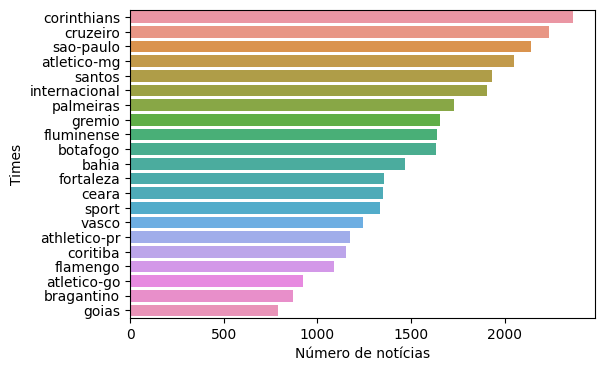

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

news_per_club = df['club'].value_counts()-

plt.figure(figsize=(6,4))
sns.barplot(x= news_per_club.values, y=news_per_club.index)
plt.xlabel('Número de notícias')
plt.ylabel('Times')
plt.show()

## Carregando os pacotes necessários

In [2]:
import nltk
import os

nltk.download('stopwords', download_dir=download_dir)
nltk.download('punkt', download_dir=download_dir)
nltk.download('rslp', download_dir=download_dir)
nltk.download('corpus')

Pacotes disponíveis na  biblioteca [SpaCy](https://spacy.io/)

In [ ]:
!python -m spacy download pt_core_news_lg

## Extração de recursos usando TF-IDF

Representação no espaço vetorial usando a classe [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn-feature-extraction-text-tfidfvectorizer) que implementa o método TF-IDF.

In [4]:
import spacy

nlp = spacy.load('pt_core_news_lg')

In [5]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('portuguese'))

tokenizer = RegexpTokenizer(r'(?u)\b\w{2,}\b')

In [6]:
from spacy.tokens import Doc
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import RSLPStemmer
import re

def stem_tokens(tokens):
  stemmer = RSLPStemmer()
  return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
  doc = Doc(nlp.vocab, words=tokens)
  doc = nlp(doc)
  return [token.lemma_ for token in doc]

def filter_existing_tokens(tokens):
  existing_tokens = [token for token in tokens if not nlp.vocab[token.lower()].is_oov]
  return existing_tokens

def remove_stopwords(tokens):
  return [token for token in tokens if token not in stop_words]

def extract_tokens(document):
  tokens = tokenizer.tokenize(document)
  tokens = [token for token in tokens if not re.match(r'\b\d{1,2}h(?:\d{1,2})?\b', token)] # Remove padrão de hora
  tokens = [token for token in tokens if not re.match(r'\b\d+x\d+\b', token)] # Remove padrão de placar de jogo
  tokens = [token for token in tokens if not re.match(r'\b\d+a\b', token)] # Remove padrão de número + a
  tokens = [token for token in tokens if not re.match(r'\b\d+as\b', token)] # Remove padrão de número + as
  tokens = [token for token in tokens if not re.match(r'^\d+$', token)] # Remove padrão de números inteiros
  tokens = [token for token in tokens if not re.match(r'\b\d+(?:ª|º)\b', token)] # Remove padrão de número ordinal
  tokens = [token for token in tokens if not re.match(r'.*[a-zA-Z].*\d|\d.*[a-zA-Z].*', token)] # Remove padrão de combinação entre letras e números
  tokens = [token for token in tokens if not token in ['ge', 'xg']] # Remove tokens específicos
  return tokens

def tokenize(document):
  tokens = extract_tokens(document)
  tokens = remove_stopwords(tokens)
  tokens = filter_existing_tokens(tokens)
  # tokens = stem_tokens(tokens) #optional
  # tokens = lemmatize_tokens(tokens) #optional
  return tokens

vectorizer = TfidfVectorizer(
  tokenizer=tokenize,
  token_pattern=None,
)

t0 = time()

X_tfidf = vectorizer.fit_transform(df.text.values)
feature_names = vectorizer.get_feature_names_out()

print(f"Vetorização finalizada em {time() - t0:.3f} s")
print(f"Número de amostras: {X_tfidf.shape[0]}, número de recursos: {X_tfidf.shape[1]}")

Vetorização finalizada em 76.976 s
Número de amostras: 32042, número de recursos: 45035


In [156]:
import pickle

token_lists = []

for document in df.text.values:
    tokens = tokenize(document)
    token_lists.append(tokens)

with open('tokens_list.txt', 'w', encoding='utf-8') as f:
    for token_list in token_lists:
        f.write(' '.join(token_list) + '\n')

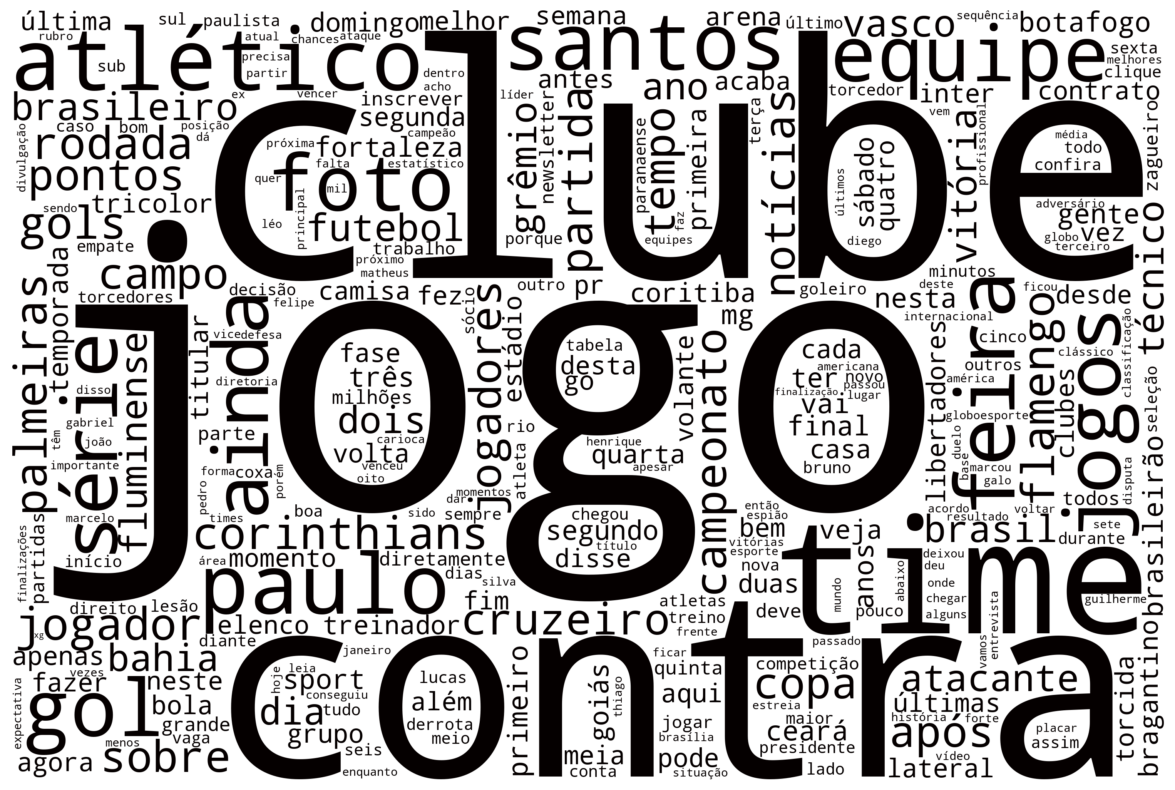

In [43]:
# https://github.com/simplykeerthana/WordCloud-Generator/blob/main/word_cloud_gen.ipynb
# https://stackoverflow.com/questions/61916096/word-cloud-built-out-of-tf-idf-vectorizer-function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

tfidf_weights = [(word, X_tfidf.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
  return('hsl(0,100%, 1%)')

w = WordCloud(
  background_color='white',
  width=3000,
  height=2000,
  max_words=300,
  color_func=black_color_func
).generate_from_frequencies(dict(tfidf_weights))

plt.figure(figsize=[15,10])
plt.imshow(w, interpolation='bilinear')
plt.axis('off')
plt.savefig('word_cloud.png', format='png')
plt.show()

## Redução de dimensionalidade usando LSA

Redução de dimensionalidade usando a técnica LSA, que utiliza o método de decomposição [TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import numpy as np

t0 = time()

lsa = make_pipeline(TruncatedSVD(n_components=32, random_state=42, n_iter=20), Normalizer(copy=False))
X_lsa = lsa.fit_transform(X_tfidf)
[svd, _] = lsa

explained_variance = svd.explained_variance_ratio_.sum()

print(f"Decomposição LSA finalizada em {time() - t0:.3f} s")
print(f"Variância da etapa SVD: {explained_variance * 100:.1f}%")

Decomposição LSA finalizada em 4.622 s
Variância da etapa SVD: 19.2%


### Importância relativa de cada componente

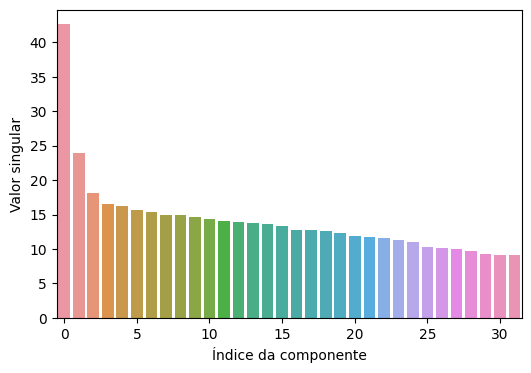

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_lsa_data = X_lsa
Sigma = svd.singular_values_
V_T = svd.components_.T

plt.figure(figsize=(6, 4))
x_positions = list(range(len(Sigma)))
ax = sns.barplot(x=x_positions, y=Sigma)
x_positions_to_label = x_positions[::5]
ax.set_xticks(x_positions_to_label)
plt.xticks(rotation=0)
plt.xlabel('Índice da componente')
plt.ylabel('Valor singular')
plt.show()

### Termos mais importantes por tópico

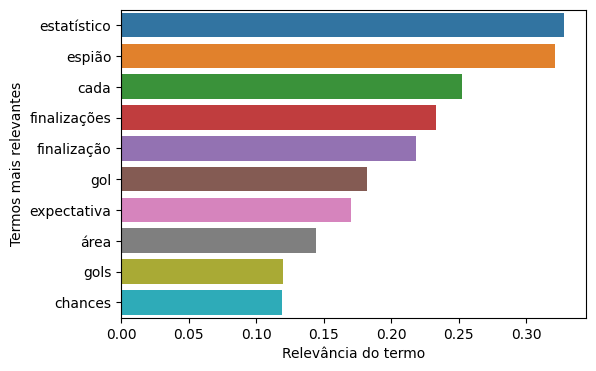

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

tfidf_train_df = pd.DataFrame(X_tfidf.toarray(), 
                        columns=feature_names)

V_T = svd.components_.T
lsa_term_topic = V_T
eda_train = tfidf_train_df

term_topic_matrix = pd.DataFrame(data=lsa_term_topic,
                                 index = eda_train.columns, 
                                 columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])

data = term_topic_matrix[f'Latent_concept_1']
data = data.sort_values(ascending=False)
top_10 = data[:10]
plt.figure(figsize=(6, 4))
sns.barplot(x= top_10.values, y=top_10.index)
plt.xlabel('Relevância do termo')
plt.ylabel('Termos mais relevantes')
plt.savefig('Latent_concept_1.svg', format='svg')
plt.show()

### Representação 3D

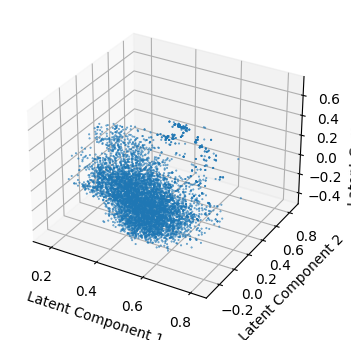

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

percentage_to_keep = 20
num_points_to_keep = int((percentage_to_keep / 100) * len(X_lsa))
sampled_indices = np.random.choice(len(X_lsa), num_points_to_keep, replace=False)
X_sampled = X_lsa[sampled_indices]

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sampled[:, 0], X_sampled[:, 1], X_sampled[:, 2], alpha=0.8, s=0.2)
ax.set_xlabel('Latent Component 1')
ax.set_ylabel('Latent Component 2')
ax.set_zlabel('Latent Component 3')
plt.show()

## Utils

In [11]:
from sklearn import metrics

def calculate_metrics(X, true_labels, predicted_labels):
  print('Homogeneity', metrics.homogeneity_score(true_labels, predicted_labels))
  print('Completeness', metrics.completeness_score(true_labels, predicted_labels))
  print('V-measure', metrics.v_measure_score(true_labels, predicted_labels))
  print('Adjusted Rand-Index', metrics.adjusted_rand_score(true_labels, predicted_labels))
  print('Fowlkes-Mallows', metrics.fowlkes_mallows_score(true_labels, predicted_labels))
  print('Normalized Mutual Information', metrics.normalized_mutual_info_score(true_labels, predicted_labels))
  print('Silhouette Coefficient', metrics.silhouette_score(X, predicted_labels))

def calculate_accuracy(df, predicted_labels):
  df['cluster_label'] = predicted_labels
  clusters = df.groupby('cluster_label')
  cluster_category = clusters['club'].agg(lambda x: x.value_counts().index[0])
  cluster_category_map = dict(zip(cluster_category.index, cluster_category.values))
  df['predicted_category'] = df['cluster_label'].map(cluster_category_map)
  success_rate = (df['club'] == df['predicted_category']).mean()
  accuracy = round(success_rate, 2)*100
  return accuracy

In [37]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import numpy as np

def grid_search_lsa(model):
    best_accuracy_score = 0
    best_n_components = 0

    model_name = model.__class__.__name__.lower()

    with open(f"grid_search_lsa_{model_name}.csv", "w") as file:
        file.write("n_components,accuracy_score\n")
    
        for n in range(20,101):
            lsa = make_pipeline(TruncatedSVD(n_components=n, random_state=42, n_iter=20), Normalizer(copy=False))
            [svd, _] = lsa
            X_lsa = lsa.fit_transform(X_tfidf)
    
            labels = model.fit_predict(X_lsa)
            df['cluster'] = labels
            accuracy = calculate_accuracy(df, labels)
    
            file.write(f"{n},{accuracy}\n")
        
            if accuracy > best_accuracy_score:
                best_accuracy_score = accuracy
                best_n_components = n
        
        return best_n_components, best_accuracy_score

kmm = KMeans(
  n_clusters = 21,
  random_state=3,
  n_init=10,
)

agg = AgglomerativeClustering(
  n_clusters = 21,
  linkage = 'ward'
)

gmm = GaussianMixture(
  n_components=21,
  covariance_type='tied',
  random_state=11
)

dbscan = DBSCAN(
    eps=0.4,
    min_samples=25
)

best_n_components, best_accuracy_score = grid_search_lsa(kmm)

print(f"Melhor número de componentes: {best_n_components}")
print(f"Melhor percentual de acurácia: {best_accuracy_score}")

265.68197321891785

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_grid_search_lsa(file_path):
    
    df = pd.read_csv(file_path)
    
    n_clusters = df['n_components']
    scores = df['accuracy_score']
    
    plt.plot(n_clusters, scores)
    plt.xlabel('Número de Componentes')
    plt.ylabel('Percentual de Acurácia')
    plt.grid(False)
    
    plt.show()

plot_grid_search_lsa('grid_search_lsa_kmeans.csv')
plot_grid_search_lsa('grid_search_lsa_gaussianmixture.csv')
plot_grid_search_lsa('grid_search_lsa_agglomerativeclustering.csv')

## Agrupamento usando K-Means

Agrupamento usando a classe [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(
  n_clusters=27,
  n_init=10,
  random_state=3
).fit(X_lsa)

labels = kmeans.labels_

df['cluster'] = labels

accuracy = calculate_accuracy(df, labels)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], labels)

Accuracy: 73.0 %
Homogeneity 0.6611896207502517
Completeness 0.6140975713377566
V-measure 0.6367741208655394
Adjusted Rand-Index 0.6165196297373688
Fowlkes-Mallows 0.6380233668115731
Normalized Mutual Information 0.6367741208655394
Silhouette Coefficient 0.3377286226704797


In [ ]:
teste={}

for cat in df['club'].unique():
  print(f"{cat}\n{df[df['club'] == cat]['cluster'].value_counts().head(2)}\n")
  a = df[df['club'] == cat]['cluster'].value_counts().head(2).index
  b = df[df['club'] == cat]['cluster'].value_counts().head(2).values
teste

In [ ]:
cluster_to_club = {}

for cat in df['club'].unique():
  mark = df['club'] == cat
  top = df[mark]['cluster'].value_counts().head(2)
  count = top.values[0]
  count1 = top.values[1]
  cluster = top.index[0]
  cluster1 = top.index[1]
  print(f"{cat}:\n Top cluster number: {cluster}, Number of samples: {count}")
  if cluster not in cluster_to_club:
    cluster_to_club[cluster] = cat
  else:
    print(f'\nOPA! {cat} não entrou como chave {cluster}!\n')

print("\nMap cluster number to club:")
cluster_to_club

## Agrupamento usando DBSCAN

Agrupamento usando a classe [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [15]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
  eps=0.4,
  min_samples=36
).fit(X_lsa)

df['cluster'] = dbscan.labels_

## Agrupamento Hierárquico Aglomerativo

Agrupamento usando a classe [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [14]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(
  n_clusters = 21,
  linkage = 'ward'
).fit(X_lsa)

df['cluster'] = agg.labels_

accuracy = calculate_accuracy(df, agg.labels_)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], agg.labels_)

Accuracy: 71.0 %
Homogeneity 0.6440553442095397
Completeness 0.6653059052783206
V-measure 0.6545081794596687
Adjusted Rand-Index 0.49490896004922014
Fowlkes-Mallows 0.5279214769503314
Normalized Mutual Information 0.6545081794596685
Silhouette Coefficient 0.2947523392196391


## Agrupamento usando Modelo de Mistura Gaussiana

Agrupamento usando a classe [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

In [16]:
from sklearn.mixture import GaussianMixture

gmm_labels = GaussianMixture(
    n_components=21,
    covariance_type='tied',
    random_state=11,
).fit_predict(X_lsa)

df['cluster'] = gmm_labels

accuracy = calculate_accuracy(df, gmm_labels)

print('Accuracy:', accuracy, '%')

calculate_metrics(X_lsa, df['club'], gmm_labels)

Accuracy: 74.0 %
Homogeneity 0.6521159117920562
Completeness 0.6630025958284117
V-measure 0.6575141932743884
Adjusted Rand-Index 0.568930075028848
Fowlkes-Mallows 0.5929912464989283
Normalized Mutual Information 0.6575141932743885
Silhouette Coefficient 0.30201415457749886


### Referências:

https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8

https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

https://medium.com/geekculture/what-text-clustering-can-tell-us-about-text-classification-248ce1d5d1e3

In [ ]:
# Método do cotovelo com kneed
from sklearn.cluster import KMeans
from kneed import KneeLocator

lista_x = []
lista_y = []

for k in range(2, 100):
 kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
 kmeans.fit(X_lsa)
 lista_x.append(k)
 lista_y.append(kmeans.inertia_)

knee = KneeLocator(lista_x, lista_y, curve='convex', direction='decreasing')
knee.plot_knee()

if knee.knee is not None:
    melhor_k = lista_x[knee.knee-2]
    print('Melhor k:', melhor_k)
else:
    print('Nenhum ponto claro de cotovelo encontrado.')

In [ ]:
# Método do cotovelo manual

inertias = []

num_clusters_range = range(1, 201)

for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=100, n_init=10, random_state=42)
    kmeans.fit(X_lsa)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo para K-Means')
plt.grid(True)

optimal_k = None
for i in range(1, len(inertias) - 1):
    diff1 = inertias[i] - inertias[i - 1]
    diff2 = inertias[i] - inertias[i + 1]
    if diff1 > 0 and diff2 > 0:
        optimal_k = i + 1
        break

if optimal_k is not None:
    plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Número Ótimo de Clusters: {optimal_k}')
    plt.legend()

plt.xticks(np.arange(0, 201, 10))
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
from itertools import product

eps_values = np.arange(0.1, 1.5, 0.1)
# eps_values = [0.4,0.5,0.6]
min_samples_values = range(2, 21)
# min_samples_values = [5]
parameter_combinations = list(product(eps_values, min_samples_values))

best_score = -1
best_params = {}

for eps, min_samples in parameter_combinations:
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X_lsa)
    try:
        score = silhouette_score(X_lsa, labels)
    except ValueError:
        score = -1

    if (score > best_score):
        best_score = score
        best_params = {
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': len(np.unique(labels)),
            'score': best_score
        }

# {'eps': 0.6, 'min_samples': 9, 'n_clusters': 7, 'score': -0.04366936339059612}
# {'eps': 0.4, 'min_samples': 20, 'n_clusters': 34, 'score': 0.2063267867037264}
print(best_params)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seu código existente aqui...

# Vamos criar 4 gráficos em uma única imagem
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Top Terms for Latent Concepts')

# Gráfico 1
data1 = term_topic_matrix['Latent_concept_1']
data1 = data1.sort_values(ascending=False)[:10]
sns.barplot(x=data1.values, y=data1.index, ax=axes[0, 0])
axes[0, 0].set_title('Latent Concept 1')

# Gráfico 2 (faça o mesmo para os outros gráficos)
data2 = term_topic_matrix['Latent_concept_2']
data2 = data2.sort_values(ascending=False)[:10]
sns.barplot(x=data2.values, y=data2.index, ax=axes[0, 1])
axes[0, 1].set_title('Latent Concept 2')

# Gráfico 3
data3 = term_topic_matrix['Latent_concept_3']
data3 = data3.sort_values(ascending=False)[:10]
sns.barplot(x=data3.values, y=data3.index, ax=axes[1, 0])
axes[1, 0].set_title('Latent Concept 3')

# Gráfico 4
data4 = term_topic_matrix['Latent_concept_4']
data4 = data4.sort_values(ascending=False)[:10]
sns.barplot(x=data4.values, y=data4.index, ax=axes[1, 1])
axes[1, 1].set_title('Latent Concept 4')

# Ajuste o layout para evitar sobreposições
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Exiba a imagem com os 4 gráficos
plt.show()

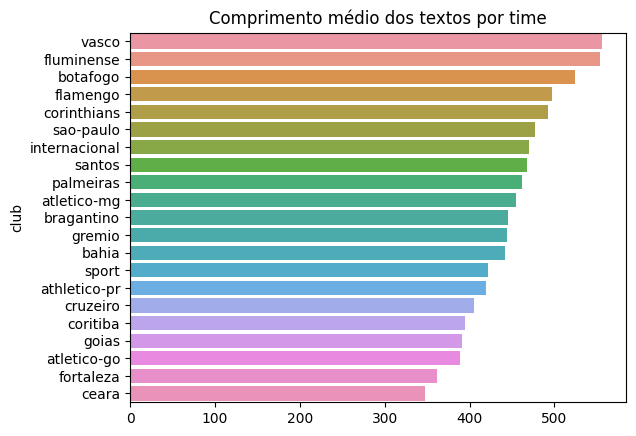

In [33]:
# Calcular o numero médio de termos das noticias por time

import seaborn as sns
import matplotlib.pyplot as plt

comprimento_medio_por_time = df.groupby('club')['text'].apply(lambda x: sum(len(texto.split()) for texto in x) / len(x)).sort_values(ascending=False)

plt.title('Comprimento médio dos textos por time')
fig = sns.barplot(x=comprimento_medio_por_time.values, y=comprimento_medio_por_time.index)

In [ ]:
from sklearn import metrics

for n in range(20, 100, 5):
    lsa = make_pipeline(TruncatedSVD(n_components=n, random_state=42, n_iter=20), Normalizer(copy=False))
    X_lsa = lsa.fit_transform(X_tfidf)
    print(f"Coeficiente de silhueta para {n} componentes: {metrics.silhouette_score(X_lsa, df['club'])}")